<a href="https://colab.research.google.com/github/aguchhait-stack/API-Call/blob/main/Times_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datetime as dt
from sklearn.metrics import mean_squared_error
color_pal=sns.color_palette()
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/AEP_hourly.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [ ]:
df.nunique()

,0
Datetime,121269
AEP_MW,12643


In [ ]:
df['Datetime']=pd.to_datetime(df['Datetime'])

In [ ]:
df.set_index("Datetime",inplace=True)

In [ ]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


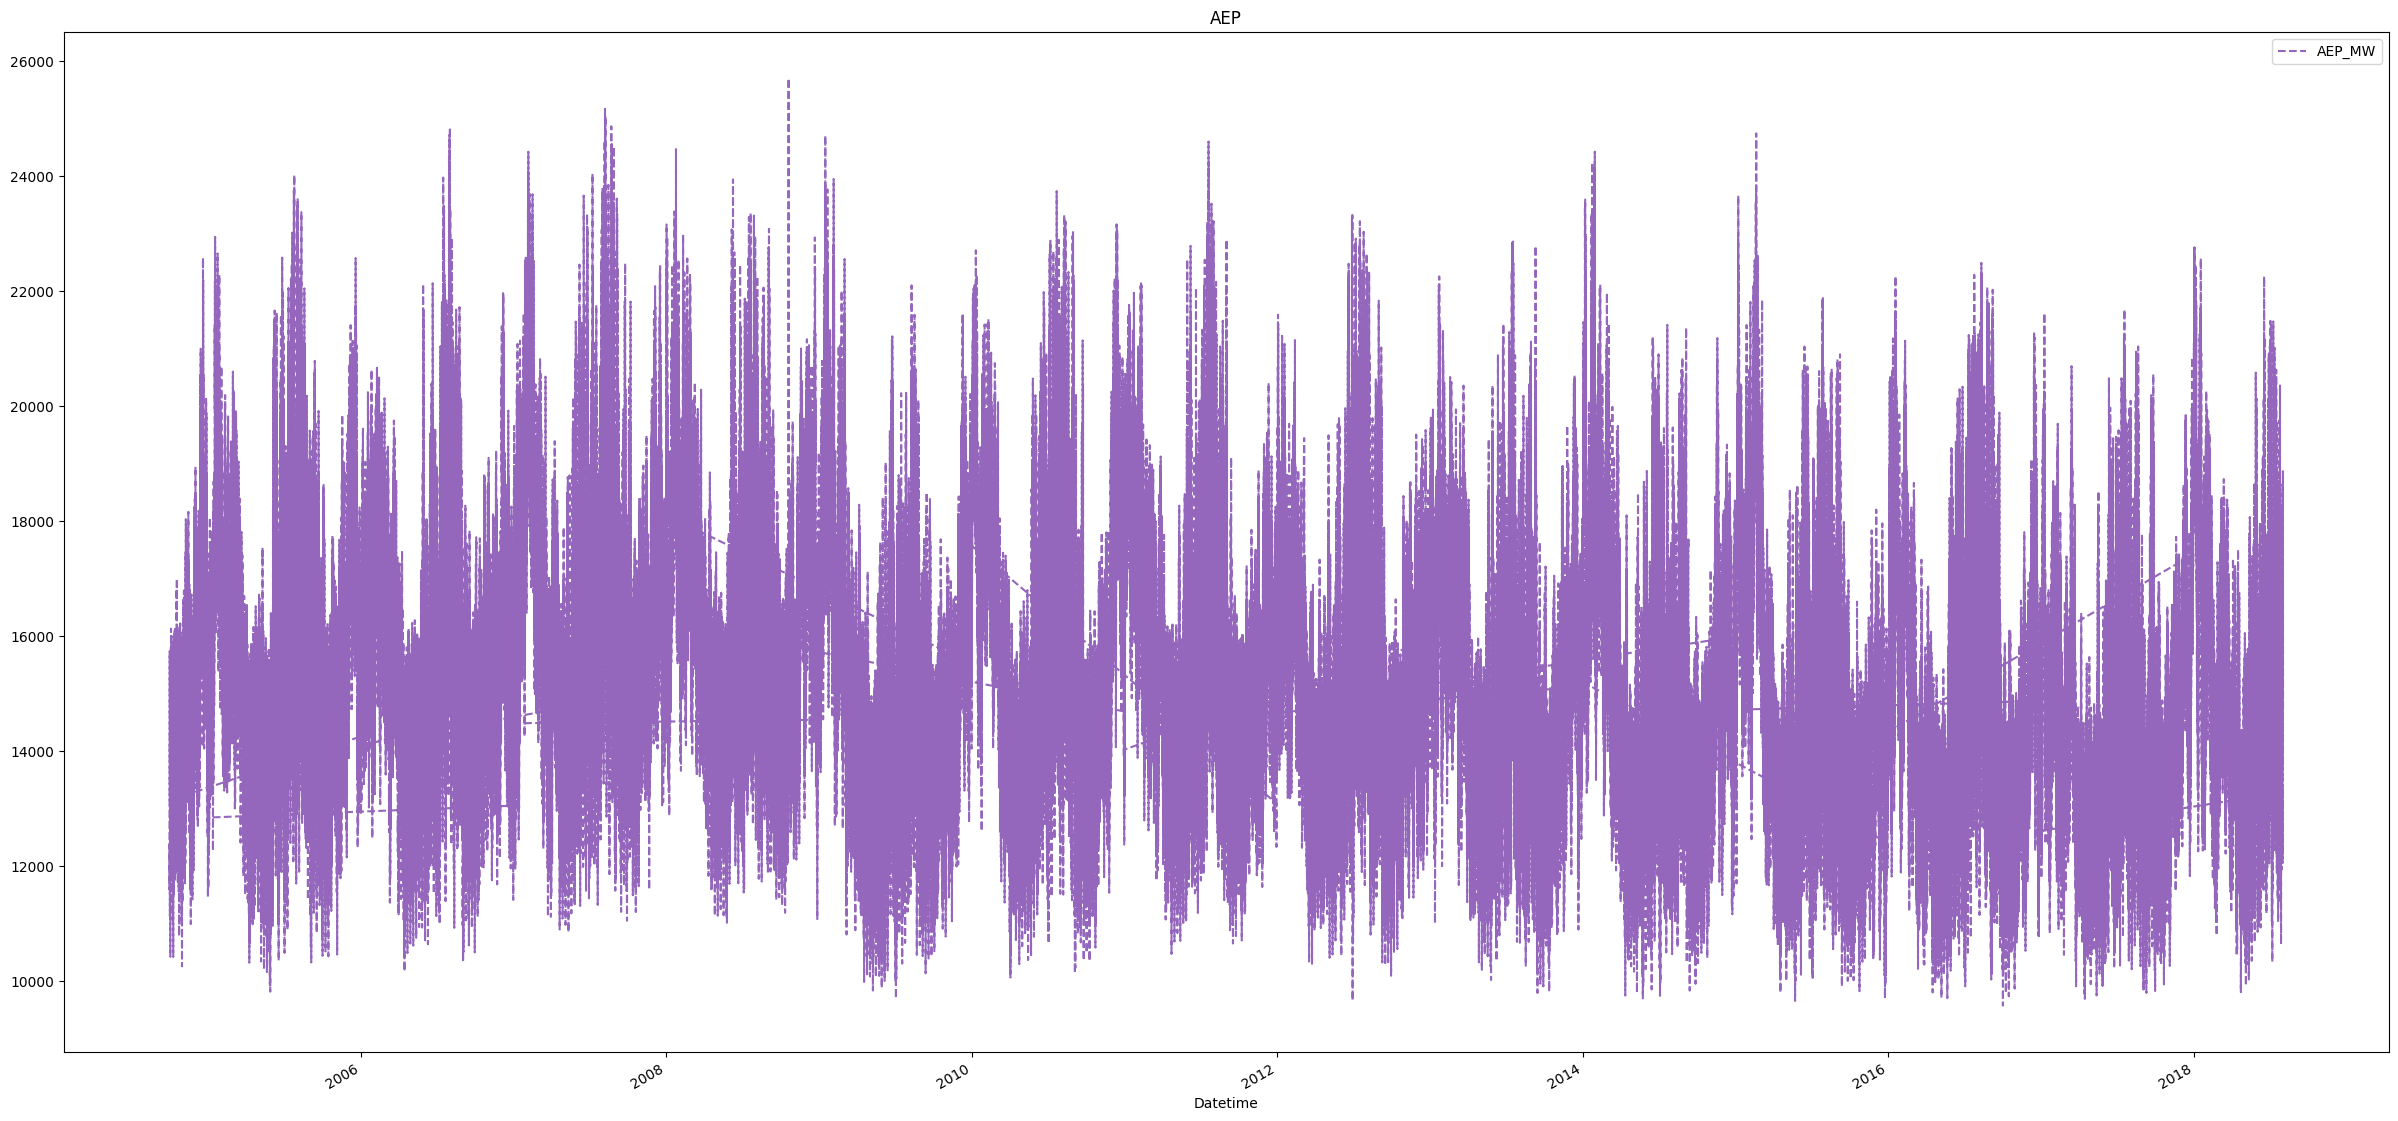

In [ ]:
df.plot(style='--',color=color_pal[4],title='AEP',figsize=(30,15))
plt.show()

In [ ]:
train =df.loc[df.index<'01-01-2015']
test= df[df.index>='01-01-2015']

In [ ]:
train.size

89833

In [ ]:
test.size

251520

# Subplot with two dataframe

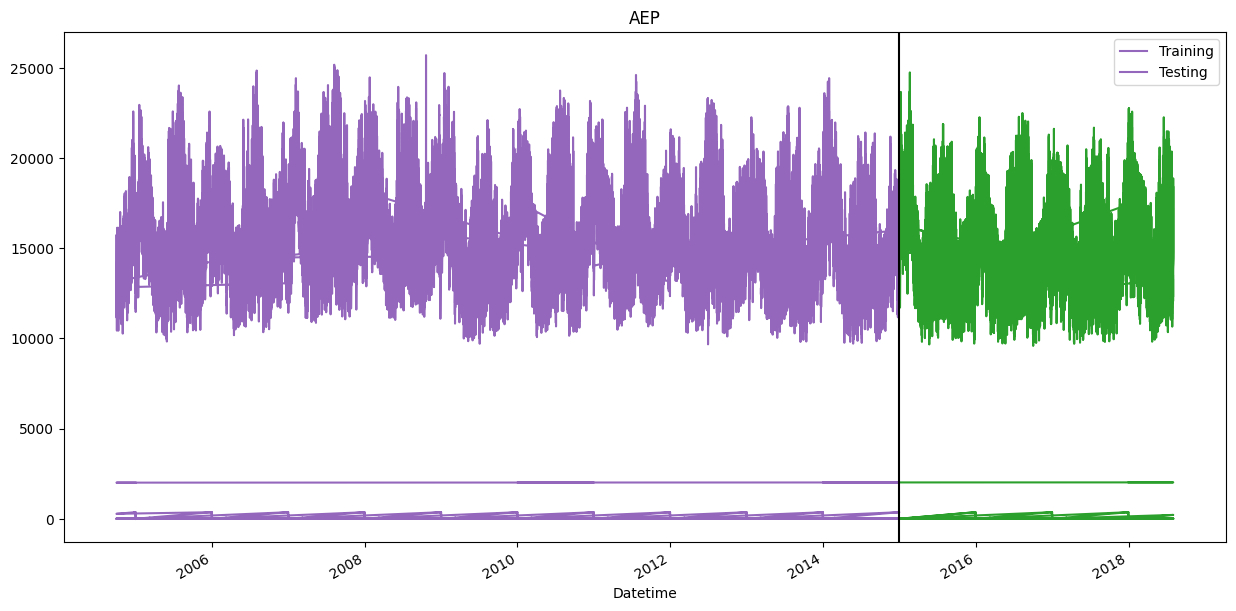

In [ ]:


fig, ax = plt.subplots(figsize=(15,7.5))
train.plot(ax=ax, label='Training Set', color=color_pal[4])
test.plot(ax=ax, label='Test Set', color=color_pal[2])
ax.axvline('01-01-2015',color='black',linestyle='-')
ax.legend(['Training','Testing'])
ax.set_title('AEP')
plt.show()

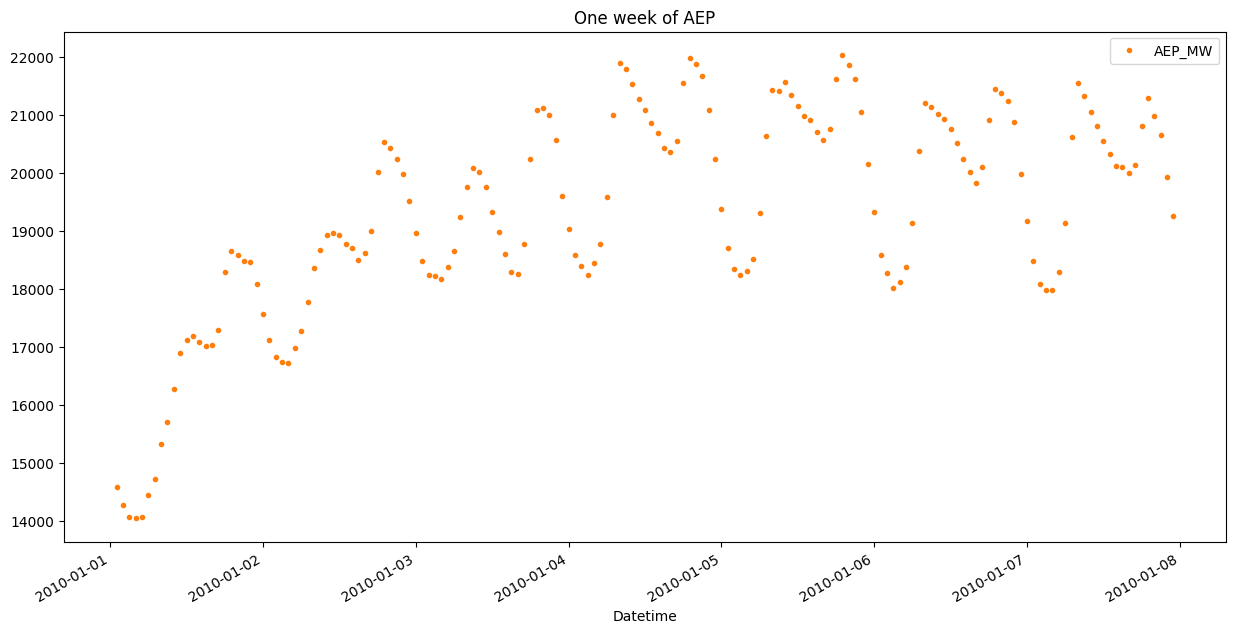

In [ ]:
df.loc[(df.index>'2010-01-01') & (df.index<'2010-01-08')].plot(figsize=(15,7.5),title='One week of AEP',style='.',color=color_pal[1])
plt.show()

# Feature Creation



In [ ]:
def create_feature(df):
    """
    create time series features based on index
    """
    df=df.copy()
    df['hour']=df.index.hour
    df['day of week']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['day of year']=df.index.day_of_year
    return df

In [ ]:
df=create_feature(df)

# Visualize our feature

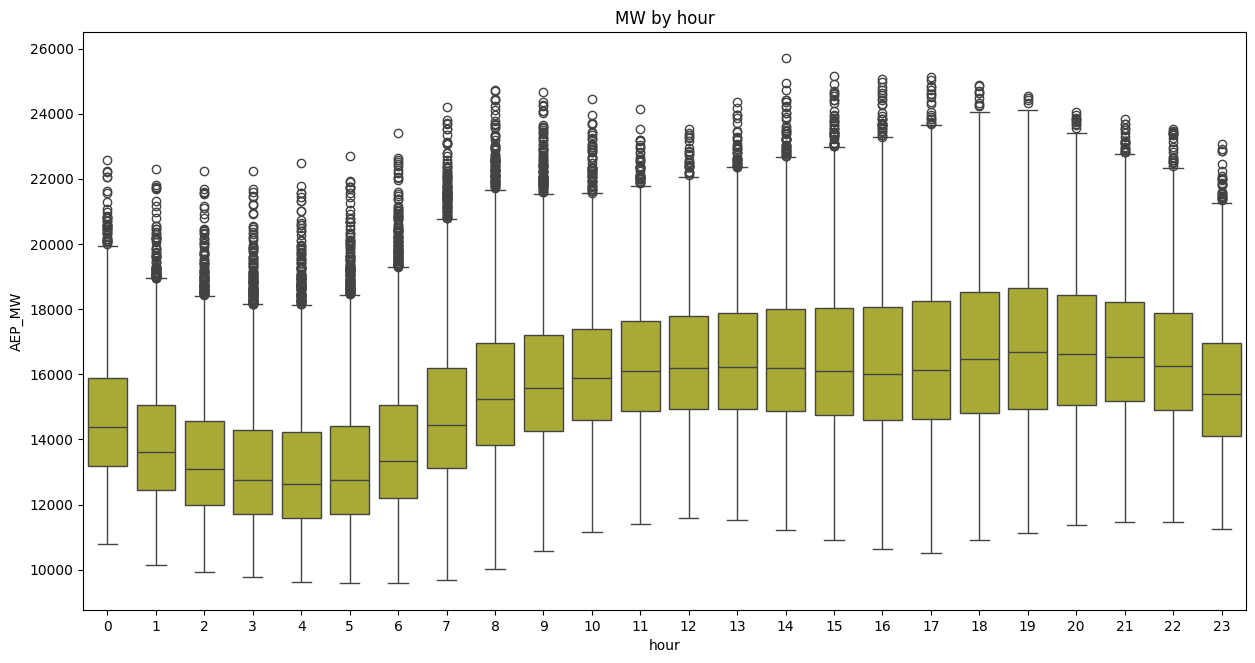

In [ ]:
fig,aw=plt.subplots(figsize=(15,7.5))
sns.boxplot(data=df,x='hour',y='AEP_MW',color=color_pal[8])
aw.set_title('MW by hour')
plt.show()

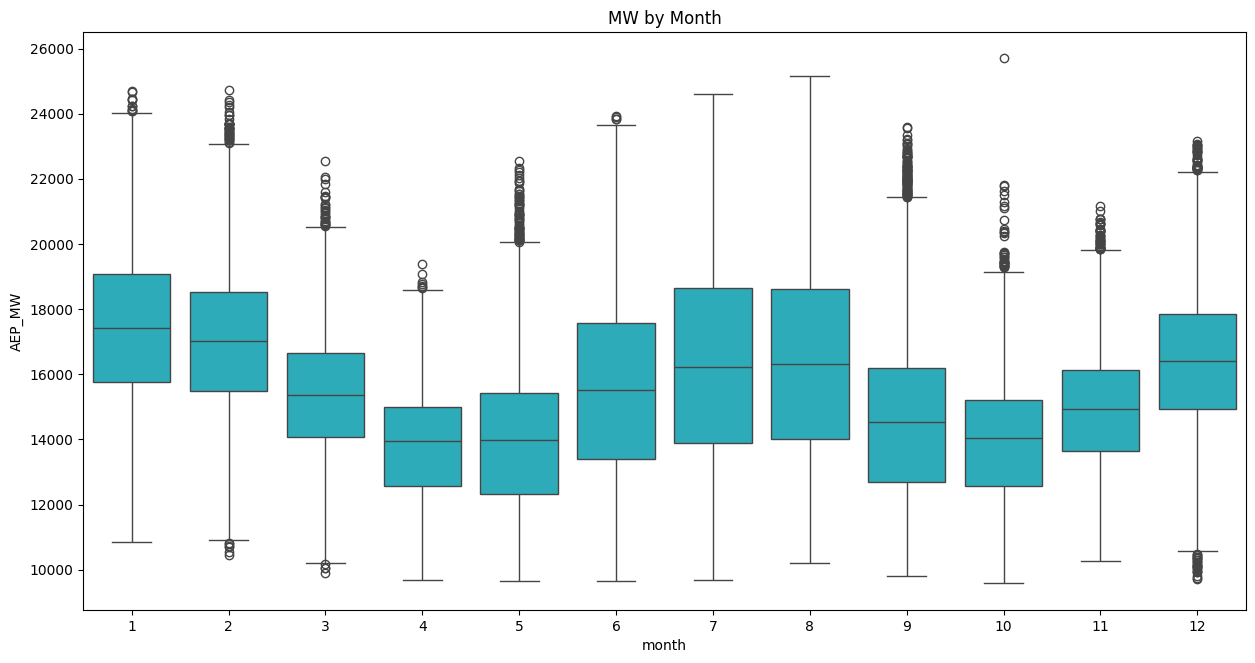

In [ ]:
fig, aw=plt.subplots(figsize=(15,7.5))
sns.boxplot(data=df,x='month',y='AEP_MW',color=color_pal[9])
aw.set_title('MW by Month')
plt.show()

# Create our Model

In [ ]:
train=create_feature(train)
test=create_feature(test)

In [ ]:
FEATURE=['hour', 'day of week', 'quarter', 'month', 'year',
       'day of year']
TARGET = 'AEP_MW'

In [ ]:
X_train=train[FEATURE]
y_train=train[TARGET]
X_test=test[FEATURE]
y_test=test[TARGET]

In [ ]:
from pickle import TRUE
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.93868
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.83339
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1644.49126
[544]	validation_0-rmse:1091.83993	validation_1-rmse:1647.10973


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
reg.feature_importances_

array([0.3977602 , 0.1675827 , 0.11199786, 0.13614446, 0.05341003,
       0.13310471], dtype=float32)

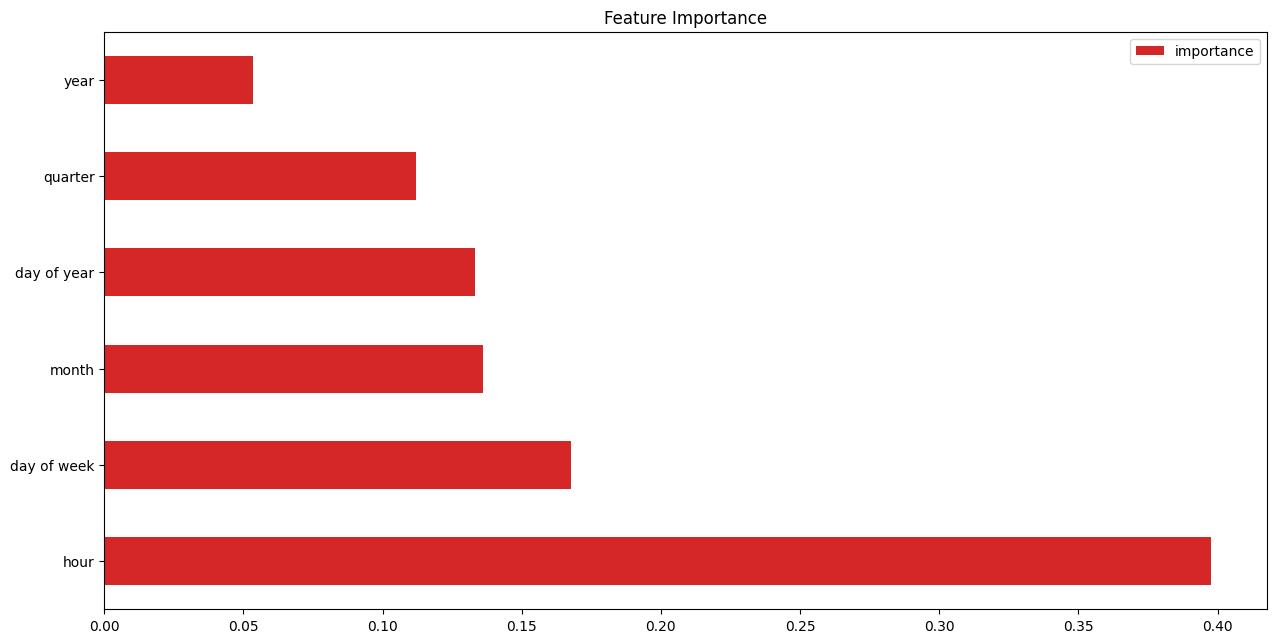

In [ ]:
fi =pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values(by='importance',ascending=False).plot(kind='barh',title='Feature Importance',figsize=(15,7.5),color=color_pal[3])
plt.show()

# Forecast

In [ ]:
test['prediction']=reg.predict(X_test)

In [ ]:
df=df.merge(test[['prediction']],how='left',left_index=True,right_index=True)


In [ ]:
df.head()

,AEP_MW,hour,day of week,quarter,month,year,day of year,prediction
Datetime,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,NaN
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,NaN
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,NaN
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,NaN
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,NaN


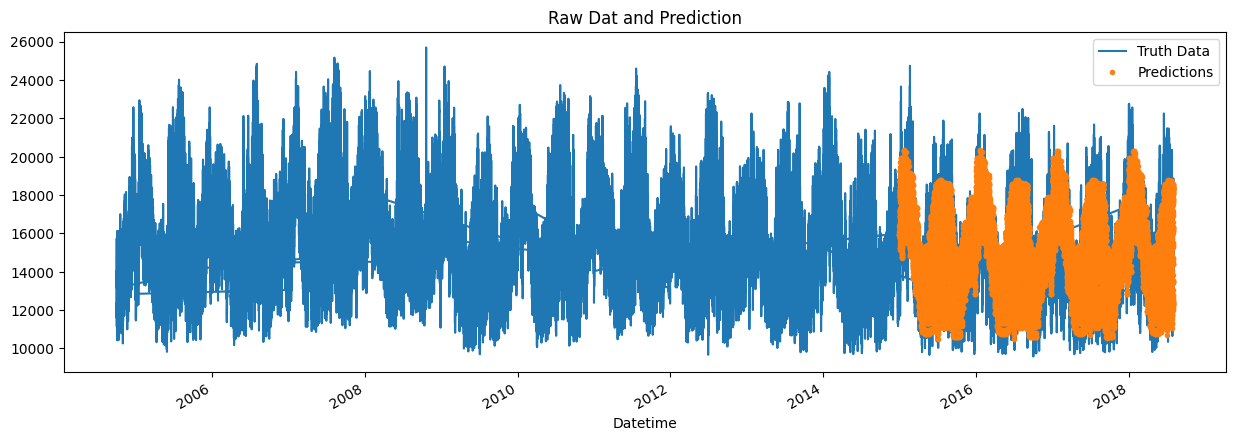

In [ ]:
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()